# minimal

In [548]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [470]:
# maze generator
def add_exit(maze):
    choices = (maze == 1).nonzero().tolist()
    furthest = max(choices, key=lambda x: x[0] + x[1])
    maze[furthest[0], furthest[1]] = -1

def make_maze(width):
    maze = torch.zeros((width, width))
    moves = list(MOVES.keys())

    def rec(x, y):
        while True:
            pairs = []
            for move in moves:
                dx, dy = move
                nx, ny = x + dx, y + dy
                nnx, nny = nx + dx, ny + dy
                if 0 <= nnx < width and 0 <= nny < width and maze[nnx, nny] == 0 and maze[nx, ny] == 0:
                    pairs.append((nx, ny, nnx, nny))
            random.shuffle(pairs)
            if not pairs: break
            nx, ny, nnx, nny = pairs[0]
            maze[nx, ny], maze[nnx, nny] = 1, 1
            rec(nnx, nny)

    maze[0, 0] = 1
    rec(0, 0)
    add_exit(maze)
    return maze

# look at the maze
maze = make_maze(24)
lookup = {0: '@', 1: '.', -1: 'x'}
print('\n'.join(''.join(lookup[i] for i in row) for row in maze.tolist()))

.@.................@...@
.@@@@@@@@@.@@@@@@@.@@@.@
.....@...@.@...@.@.....@
@@@@.@.@.@.@.@.@.@@@@@.@
.....@.@...@.@...@...@.@
.@@@@@.@@@@@.@@@@@.@.@.@
.@.........@.......@.@.@
.@@@@@@@.@.@@@@@.@@@.@.@
.......@.@.@...@...@.@.@
@@@@@@.@@@.@.@.@@@@@.@.@
.@.....@...@.@.@...@.@.@
.@.@@@@@.@@@.@.@.@.@.@.@
...@.....@...@...@...@.@
.@@@.@@@@@.@@@@@@@@@.@.@
.@...@.....@...@.....@.@
.@@@.@.@.@@@.@.@@@.@@@.@
.@...@.@.@...@...@.@...@
.@.@@@@@.@.@@@@@.@@@.@@@
.@.....@.......@...@...@
.@@@@@.@@@@@@@.@@@.@@@.@
.....@.....@.@.@.@...@.@
@@@@.@@@@@.@.@.@.@@@.@.@
...........@.......@..x@
@@@@@@@@@@@@@@@@@@@@@@@@


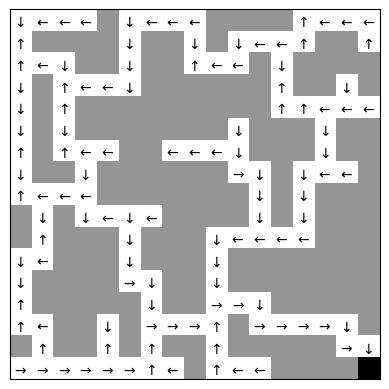

In [566]:
def plot_policy(model, maze):
    dirs = {
        0: '↑',
        1: '↓',
        2: '←',
        3: '→',
    }
    with torch.no_grad():
        fig, ax = plt.subplots()
        ax.imshow(-maze, 'Greys')
        for pos in (maze == 1).nonzero().tolist():
            q = model(to_input(maze, pos))
            action = int(torch.argmax(q).detach().cpu().item())
            dir = dirs[action]
            ax.text(pos[1] - 0.3, pos[0] + 0.3, dir) # center arrows in empty slots
        
        plt.xticks([], [])
        plt.yticks([], [])
        plt.show()

# plot_policy(model, default_maze)

In [585]:
# solve after 40s of training 5000/128
# default_maze = torch.tensor([
#     [1, 0, 0, 0, 0],
#     [1, 1, 1, 1, 1],
#     [0, 1, 0, 1, 0],
#     [1, 1, 0, 0, 0],
#     [1, 1, 1, 1, -1],
# ])

default_maze = torch.tensor([
    [1, 1, 1, 1, 1],
    [0, 0, 0, 1, 0],
    [1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0],
    [1, 1, 1, 1, -1],
])

# default_maze = torch.tensor([
#     [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
#     [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
#     [0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
#     [0, 1, 1, 1, 1, 1, 1, 0, 0, 1],
#     [0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
#     [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 1, 1, 1, 1, 1, -1],
# ])

# doesn't solve even after 2h of training 100000/512
# default_maze = torch.tensor([
#     [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
#     [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1],
#     [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
#     [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
#     [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
#     [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
#     [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
#     [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0],
#     [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
#     [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
#     [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
#     [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
#     [1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
#     [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
#     [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0],
#     [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
#     [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, -1],
# ])

default_maze = torch.tensor([
    [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1],
    [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0],
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, -1],
])


MAZE_WIDTH = default_maze.shape[0]
INPUT_SIZE = MAZE_WIDTH * MAZE_WIDTH + 2 * MAZE_WIDTH
MOVES = {
    (-1, 0): torch.tensor(0).to(device), # up
    (1, 0):  torch.tensor(1).to(device), # down
    (0, -1): torch.tensor(2).to(device), # left
    (0, 1):  torch.tensor(3).to(device),  # right
 }

# policy
HIT_WALL_PENALTY = -1
MOVE_PENALTY = 0
WIN_REWARD = 10
 
# hyperparams
# BATCH_SIZE = 128
EPOCH = 1000
BATCH_SIZE = 512
# EPOCH = 100000
# EPOCH = 5000
# LEARNING_RATE = 3e-4
LEARNING_RATE = 1e-3

def get_maze():
    maze = default_maze
    # maze = make_maze(MAZE_WIDTH)
    rewards = torch.zeros_like(maze)
    rewards[maze == 0] = HIT_WALL_PENALTY
    rewards[maze == 1] = MOVE_PENALTY
    rewards[maze == -1] = WIN_REWARD
    return maze, rewards

def get_reward(rewards, pos):
    x, y = pos
    a, b = rewards.shape
    if 0 <= x < a and 0 <= y < b:
        return rewards[x, y]
    return HIT_WALL_PENALTY

# random edition
# --------------
# def get_next_pos(maze, rewards, pos):
#     new_pos = pos # default to bouncing off a wall.
#     reward = HIT_WALL_PENALTY # default to hitting a wall.
#     move = random.choice(list(MOVES.keys()))
#     x, y = pos
#     a, b = maze.shape
#     i, j = move
#     if 0 <= x + i < a and 0 <= y + j < b:
#         # if maze[x + i, y + j] != -1:
#         new_pos = (x + i, y + j)
#         reward = get_reward(rewards, new_pos)
#     return new_pos, reward, move

# def get_batch():
#     batch = []
#     maze, rewards = get_maze()
#     positions = random.choices((maze == 1).nonzero().tolist(), k=BATCH_SIZE)
#     for pos in positions:
#         new_pos, reward, move = get_next_pos(maze, rewards, pos)
#         batch.append((pos, move, new_pos, reward))
#     return maze, batch

# cheating edition
# ----------------
def get_next_pos(maze, rewards, pos, move):
    new_pos = pos # default to bouncing off a wall.
    reward = HIT_WALL_PENALTY # default to hitting a wall.
    x, y = pos
    a, b = maze.shape
    i, j = move
    if 0 <= x + i < a and 0 <= y + j < b:
        # if maze[x + i, y + j] != -1:
        new_pos = (x + i, y + j)
        reward = get_reward(rewards, new_pos)
    return new_pos, reward, move


def get_batch():
    batch = []
    maze, rewards = get_maze()
    for pos in (maze == 1).nonzero().tolist():
        # if pos[0] < 13 or pos[1] < 13: continue # TODO remove XXX <-----------
    # for pos in positions:
        for mm in list(MOVES.keys()):
            new_pos, reward, move = get_next_pos(maze, rewards, pos, mm)
            batch.append((pos, move, new_pos, reward))
    return maze, batch

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # hidden_size = 128
        hidden_size = INPUT_SIZE
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(INPUT_SIZE, hidden_size),
            # nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            # nn.Linear(hidden_size, hidden_size),
            # nn.ReLU(),
            # nn.Linear(hidden_size, hidden_size),
            # nn.ReLU(),
            # nn.Linear(hidden_size, hidden_size),
            # nn.ReLU(),
            # nn.Linear(hidden_size, hidden_size),
            # nn.ReLU(),
            nn.Linear(hidden_size, len(MOVES)),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)        
        return logits

def to_input(maze, pos):
    return torch.cat((
        maze.view(-1),
        F.one_hot(torch.tensor(pos), num_classes=MAZE_WIDTH).view(-1),
    )).float().to(device)

def train(model):
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    losses = []
    for epoch in range(EPOCH):
        maze, batch = get_batch()

        # train vectorized
        # ----------------
        xs, ms, ys, rs, nuke = [], [], [], [], []
        for pos, move, new_pos, reward in batch:
            xs.append(to_input(maze, pos))
            ms.append(F.one_hot(MOVES[move], num_classes=len(MOVES)))
            ys.append(to_input(maze, new_pos))
            rs.append(reward)
            nuke.append(0. if reward != 0 else 1.)
            # nuke.append(0. if reward == -1 else 1.)

        XS = torch.stack(xs).to(device)
        MS = torch.stack(ms).to(device)
        YS = torch.stack(ys).to(device)
        RS = torch.tensor(rs).to(device).view(-1, 1)
        NUKE = torch.tensor(nuke).to(device).view(-1, 1)
        bellman_left = (model(XS) * MS).sum(dim=1, keepdim=True)
        qqs = model(YS).max(dim=1, keepdim=True).values

        decay = 0.95
        bellman_right = RS + qqs * NUKE * decay
        
        loss = F.mse_loss(bellman_left, bellman_right)
        losses.append(loss.item())
        if epoch % 50 == 49:
            print(f"epoch: {epoch: 5} loss: {torch.tensor(losses).mean():.8f}")
            losses = []
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # train non-vectorized
        # --------------------
        # lefts, rights = [], []
        # for pos, move, new_pos, reward in batch:
        #     qs = model(to_input(maze, pos))
        #     hot = F.one_hot(MOVES[move], num_classes=len(MOVES))
        #     bellman_left = (qs * hot).sum()

        #     # bellman
        #     # Q(pos, move) = reward + max(Q(new_pos, each_move))

        #     new_q = model(to_input(maze, new_pos)).max()
        #     bellman_right = reward + new_q

        #     lefts.append(bellman_left)
        #     rights.append(bellman_right)
        
        # bellman_left = torch.stack(lefts).to(device)
        # bellman_right = torch.stack(rights).to(device)
        # loss = F.mse_loss(bellman_left, bellman_right)
        # losses.append(loss.item())
        # if epoch % 50 == 0:
        #     print(f"epoch: {epoch: 5} loss: {torch.tensor(losses).mean():.8f}")
        #     losses = []
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()

model = NeuralNetwork().to(device)
train(model)

epoch:    49 loss: 0.26712665
epoch:    99 loss: 0.22426766
epoch:   149 loss: 0.20015095
epoch:   199 loss: 0.18342477
epoch:   249 loss: 0.14403927
epoch:   299 loss: 0.10806943
epoch:   349 loss: 0.09049034
epoch:   399 loss: 0.07531557
epoch:   449 loss: 0.07123272
epoch:   499 loss: 0.06942285
epoch:   549 loss: 0.06677379
epoch:   599 loss: 0.06292655
epoch:   649 loss: 0.05864755
epoch:   699 loss: 0.05505210
epoch:   749 loss: 0.05300812
epoch:   799 loss: 0.04903485
epoch:   849 loss: 0.04452707
epoch:   899 loss: 0.03770465
epoch:   949 loss: 0.03061240
epoch:   999 loss: 0.02764476


In [590]:
i2move = {i.detach().item(): v for v, i in MOVES.items()}

def play(model, maze, pos=(0, 0)):
    depth = 1000
    while True:
        qs = model(to_input(maze, pos))
        # print(f'{qs=}')
        move = i2move[qs.argmax().tolist()]
        new_pos = (pos[0] + move[0], pos[1] + move[1])
        print(f'chose {move} from {pos} to {new_pos}')
        if 0 <= new_pos[0] < MAZE_WIDTH and 0 <= new_pos[1] < MAZE_WIDTH:
            pos = new_pos
            if maze[pos] == -1:
                print("WIN")
                break
            elif maze[pos] == 0:
                print("LOSE: HIT WALL")
                break
        else:
            print("LOSE: OUTSIDE MAZE")
            break
        depth -= 1
        if depth == 0:
            print("LOSE: TOO DEEP")
            break

def debug():
    print(default_maze)
    for x, y in [(15, 16), (15, 15), (14, 15), (14, 14), (14, 13), (14, 12)]:
        qs = model(to_input(default_maze, (x, y)))
        print(f'{x}, {y} -> {qs}')

# debug()
# plot_policy(model, default_maze)
play(model, default_maze, pos=(0, 0))


chose (1, 0) from (0, 0) to (1, 0)
chose (1, 0) from (1, 0) to (2, 0)
chose (1, 0) from (2, 0) to (3, 0)
chose (1, 0) from (3, 0) to (4, 0)
chose (1, 0) from (4, 0) to (5, 0)
chose (1, 0) from (5, 0) to (6, 0)
chose (1, 0) from (6, 0) to (7, 0)
chose (1, 0) from (7, 0) to (8, 0)
chose (0, 1) from (8, 0) to (8, 1)
chose (1, 0) from (8, 1) to (9, 1)
chose (1, 0) from (9, 1) to (10, 1)
chose (1, 0) from (10, 1) to (11, 1)
chose (0, -1) from (11, 1) to (11, 0)
chose (1, 0) from (11, 0) to (12, 0)
chose (1, 0) from (12, 0) to (13, 0)
chose (1, 0) from (13, 0) to (14, 0)
chose (0, 1) from (14, 0) to (14, 1)
chose (1, 0) from (14, 1) to (15, 1)
chose (1, 0) from (15, 1) to (16, 1)
chose (0, 1) from (16, 1) to (16, 2)
chose (0, 1) from (16, 2) to (16, 3)
chose (0, 1) from (16, 3) to (16, 4)
chose (0, 1) from (16, 4) to (16, 5)
chose (0, 1) from (16, 5) to (16, 6)
chose (-1, 0) from (16, 6) to (15, 6)
chose (-1, 0) from (15, 6) to (14, 6)
chose (0, 1) from (14, 6) to (14, 7)
chose (0, 1) from (

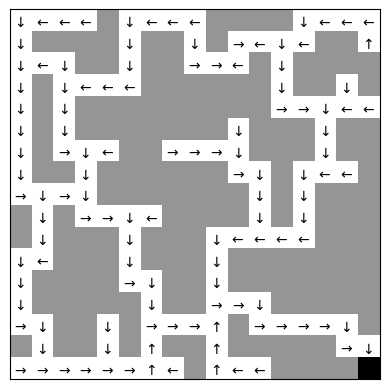

In [589]:
plot_policy(model, default_maze)

In [588]:
for i in range(10): train(model)
# train(model)

epoch:    49 loss: 0.08497471
epoch:    99 loss: 0.02769399
epoch:   149 loss: 0.02525310
epoch:   199 loss: 0.02459484
epoch:   249 loss: 0.02426808
epoch:   299 loss: 0.02405106
epoch:   349 loss: 0.02384485
epoch:   399 loss: 0.02365470
epoch:   449 loss: 0.02349022
epoch:   499 loss: 0.02328756
epoch:   549 loss: 0.02341633
epoch:   599 loss: 0.02292069
epoch:   649 loss: 0.02314157
epoch:   699 loss: 0.02244638
epoch:   749 loss: 0.02278370
epoch:   799 loss: 0.02228676
epoch:   849 loss: 0.02189729
epoch:   899 loss: 0.02179198
epoch:   949 loss: 0.02158731
epoch:   999 loss: 0.02070456
epoch:    49 loss: 0.04289898
epoch:    99 loss: 0.02098618
epoch:   149 loss: 0.02026140
epoch:   199 loss: 0.02001299
epoch:   249 loss: 0.01979056
epoch:   299 loss: 0.01948215
epoch:   349 loss: 0.01911923
epoch:   399 loss: 0.01876605
epoch:   449 loss: 0.01809252
epoch:   499 loss: 0.01786200
epoch:   549 loss: 0.01758079
epoch:   599 loss: 0.01721508
epoch:   649 loss: 0.01693684
epoch:   6

In [137]:
[x for x in get_batch()[1] if x[0] == [4, 3]]

[([4, 3], (0, -1), (4, 2), tensor(0))]

In [206]:
# backup to disk
# torch.save(model.state_dict(), 'default-maze.pt')

# m = NeuralNetwork()
# m.load_state_dict(torch.load('bigger-maze.pt'))

In [591]:
# save
# torch.save(model.state_dict(), 'maze-17x17-nuke-cheat-partial-but-better-solve.pt')